In [1]:
!pip install tensorly
!pip install lifelines
pip install jive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 350.7/350.7 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.0/91.0 kB 10.3 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=1dc8095ae4604e224f314f2c12b99eff352f7997ebcf0e476699d762a2ca0dbb
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac
from tensorly.decomposition import non_negative_parafac

# Load your data
rnaseq_df = pd.read_excel('/content/drive/MyDrive/RNAseq_128_filtered.xlsx')
mirna_df = pd.read_excel('/content/drive/MyDrive/miRNASeq_128_filtered.xlsx')
methylation_df = pd.read_excel('/content/drive/MyDrive/Methylation_128_filtered.xlsx')
image_df = pd.read_excel('/content/drive/MyDrive/all_images_lung_128_filtered_unique.xlsx')
image_df.shape

(447, 129)

In [34]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt


# Standardize data
scaler = StandardScaler()
methylation_scaled = scaler.fit_transform(methylation_df.drop('attrib_name', axis=1))
rnaseq_scaled = scaler.fit_transform(rnaseq_df.drop('attrib_name', axis=1))
mirna_scaled = scaler.fit_transform(mirna_df.drop('attrib_name', axis=1))
image_features_scaled = scaler.fit_transform(image_df.drop('attrib_name', axis=1))



# PCA
pca_methylation = PCA(n_components=2).fit_transform(methylation_scaled)
pca_rnaseq = PCA(n_components=2).fit_transform(rnaseq_scaled)
pca_mirna = PCA(n_components=2).fit_transform(mirna_scaled)
pca_image = PCA(n_components=2).fit_transform(image_features_scaled)





combined_pca_df = pd.DataFrame({
    'PCA_Methylation_1': pca_methylation[:, 0],
    'PCA_Methylation_2': pca_methylation[:, 1],
    'PCA_RNAseq_1': pca_rnaseq[:, 0],
    'PCA_RNAseq_2': pca_rnaseq[:, 1],
    'PCA_miRNA_1': pca_mirna[:, 0],
    'PCA_miRNA_2': pca_mirna[:, 1],
    'PCA_Image_1': pca_image[:, 0],
    'PCA_Image_2': pca_image[:, 1],
    'attrib_name': methylation_df['attrib_name']
})





In [35]:
# 1. import clinical.xlsx
data_methylation = pd.read_excel('/content/drive/MyDrive/Methylation_128_filtered.xlsx')
data_clinical = pd.read_excel('/content/drive/MyDrive/Clinical_lung.xlsx')
selected_samples = data_methylation.iloc[:, 0].unique()
data = data_clinical[data_clinical['attrib_name'].isin(selected_samples)]



# 1. delete NA within “overall_survival” and “status”.
data = data.dropna(subset=['overall_survival', 'status'])

# 2. replace the NA with 0 in the number type of columns.
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
data[num_cols] = data[num_cols].fillna(0)

# 3. replace the NA with "No value" in the character type of columns.
text_cols = data.select_dtypes(include=['object']).columns
data[text_cols] = data[text_cols].fillna('No value')




data = data.set_index('attrib_name')
data.index = data.index.astype(str)

merged_data = data.merge(combined_pca_df, left_index=True, right_on='attrib_name')
merged_data

,years_to_birth,Tumor_purity,pathologic_stage,pathology_T_stage,pathology_N_stage,pathology_M_stage,histological_type,gender,radiation_therapy,residual_tumor,...,overallsurvival,PCA_Methylation_1,PCA_Methylation_2,PCA_RNAseq_1,PCA_RNAseq_2,PCA_miRNA_1,PCA_miRNA_2,PCA_Image_1,PCA_Image_2,attrib_name
385,66.0,0.6937,stageiii,t2,n2,m0,lungadenocarcinomamixedsubtype,male,yes,No value,...,"426,0",3.180309,0.487955,-3.623592,4.133159,-5.490995,1.226887,-1.095133,-1.394413,TCGA.05.4384
396,76.0,0.8575,stageiii,t4,n1,m0,lungadenocarcinomamixedsubtype,male,No value,r0,...,"303,1",7.237822,2.447423,0.480326,7.254789,-2.516034,5.304342,-4.499175,3.258649,TCGA.05.4396
357,74.0,0.5920,stagei,t2,n0,m0,lungadenocarcinomamixedsubtype,female,no,r0,...,"610,0",-4.057194,4.604383,-1.034690,0.821258,-2.350164,2.092144,-3.549968,2.172105,TCGA.05.4405
430,65.0,0.6325,stageii,t2,n1,m0,lungadenocarcinomamixedsubtype,female,no,r0,...,"791,0",2.979447,-2.064906,3.962492,1.793882,-1.610573,3.321003,-2.989155,1.255600,TCGA.05.4427
431,67.0,0.3563,stageiii,t2,n2,m0,lungadenocarcinoma-nototherwisespecified(nos),male,No value,r0,...,"457,0",-3.412970,-5.140814,2.402440,-1.994295,2.063945,4.753392,13.335142,-5.296675,TCGA.05.5420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,69.0,0.4331,stagei,t1,n0,m0,lungadenocarcinoma-nototherwisespecified(nos),female,no,No value,...,"1432,0",-5.597558,-3.448203,1.220826,-3.327504,0.486563,-2.557957,-1.790717,-0.444793,TCGA.NJ.A4YQ
163,67.0,0.7913,stagei,t1,n0,No value,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,...,"603,0",-0.004475,-4.346046,-1.370855,0.701649,-1.429079,-2.275932,-3.277861,1.703924,TCGA.NJ.A55R
162,49.0,0.7730,stageiii,t4,n1,m0,lungadenocarcinoma-nototherwisespecified(nos),male,no,No value,...,"617,0",5.568402,7.276840,-3.592985,3.987009,-4.138130,-2.241758,8.404854,-5.281578,TCGA.NJ.A7XG
161,74.0,0.6489,stagei,t1,n0,No value,lungadenocarcinoma-nototherwisespecified(nos),female,no,No value,...,"1798,1",2.007283,-0.642526,-4.185993,0.084891,-1.427014,-3.336422,0.084787,-1.778834,TCGA.O1.A52J


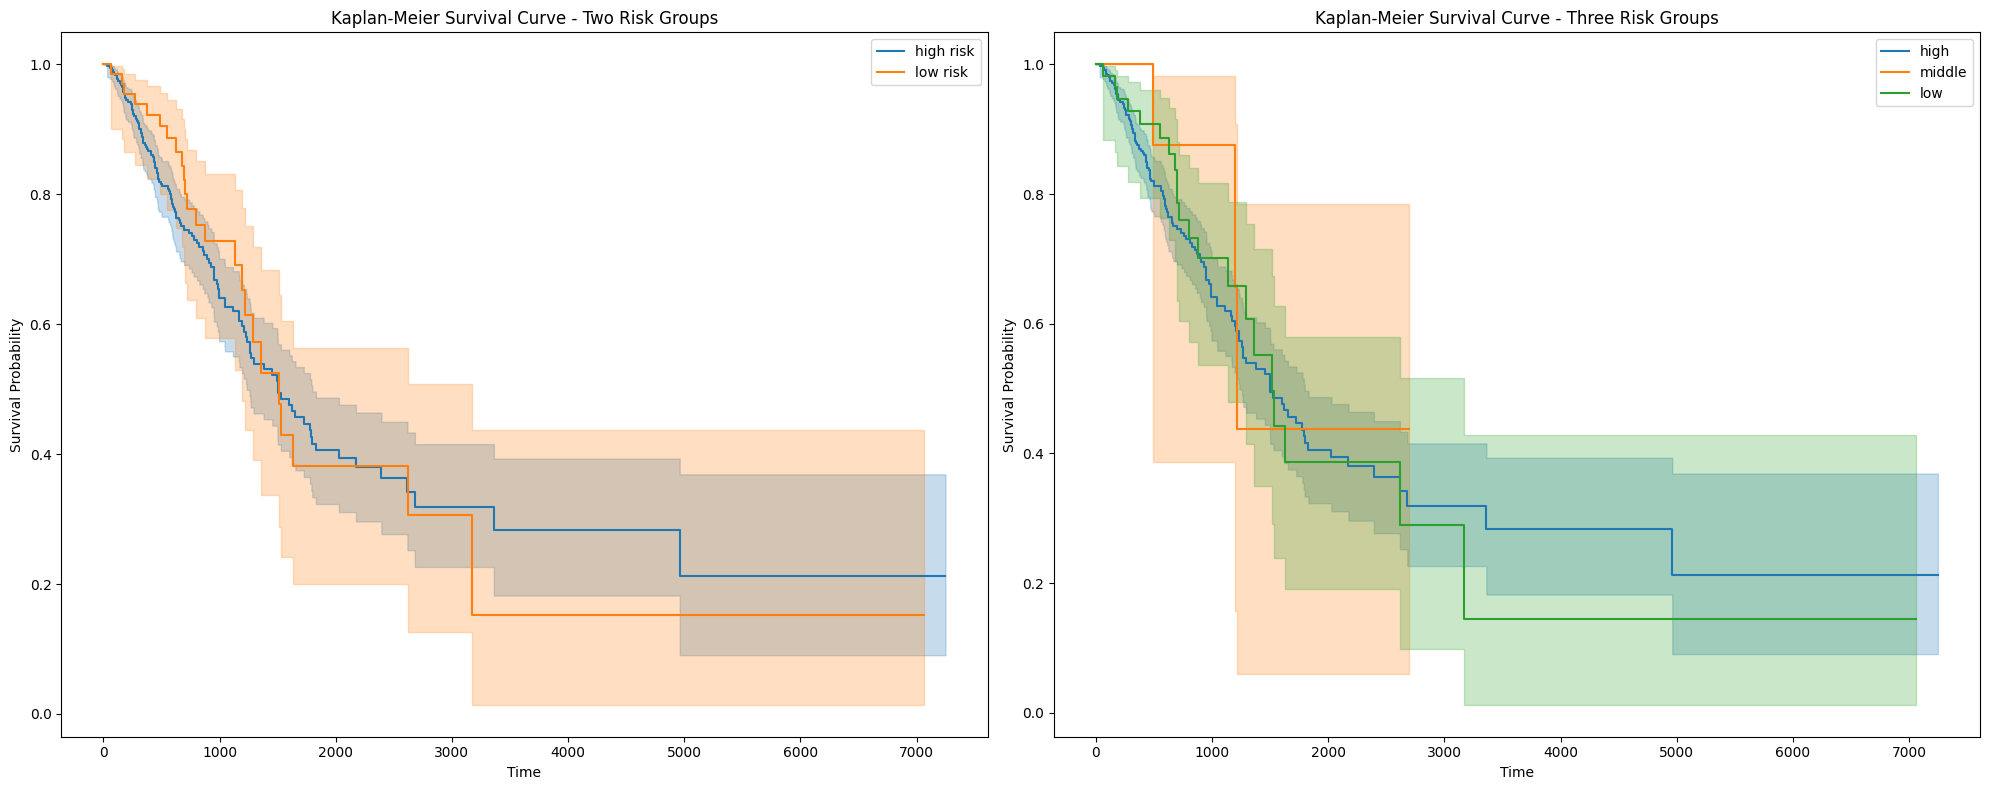

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from lifelines import KaplanMeierFitter

# delect three columns in the merged data
new_df = merged_data.drop(columns=['overall_survival', 'status',"years_to_birth"])
numeric_data_new = new_df.select_dtypes(include=[np.number])

# use Hierarchical clustering to clustering
linked = linkage(numeric_data_new, 'ward')

# create 2 and 3 risk groups seperately.
label_2_clusters = fcluster(linked, 2, criterion='maxclust')
label_3_clusters = fcluster(linked, 3, criterion='maxclust')

processed_data_new = merged_data.copy()

# add back these labels back to the dataset
processed_data_new['risk_group_2'] = label_2_clusters
processed_data_new['risk_group_3'] = label_3_clusters


kmf = KaplanMeierFitter()

# use Kaplan-Meier to do the survival test for 2 risk groups
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
risk_labels_2 = {1: "high risk", 2: "low risk"}
for label in np.unique(label_2_clusters):
    mask = processed_data_new['risk_group_2'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_2[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Two Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

# use Kaplan-Meier to do the survival test for 3 risk groups
plt.subplot(1, 2, 2)
risk_labels_3 = {1: "high", 2: "middle", 3: "low"}
for label in np.unique(label_3_clusters):
    mask = processed_data_new['risk_group_3'] == label
    group_data = processed_data_new[mask]

    kmf.fit(group_data['overall_survival'], event_observed=group_data['status'], label=risk_labels_3[label])
    kmf.plot(ax=plt.gca())

plt.title('Kaplan-Meier Survival Curve - Three Risk Groups')
plt.xlabel('Time')
plt.ylabel('Survival Probability')

plt.tight_layout()
plt.show()


In [39]:
from lifelines.statistics import logrank_test

# calculate the P-value for 2 risk groups
group1 = processed_data_new[processed_data_new['risk_group_2'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_2'] == 2]
results_2 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
p_value_2 = results_2.p_value
print(f"P-value for the difference between two risk groups: {p_value_2}")

# calculate the P-value for 3 risk groups
group1 = processed_data_new[processed_data_new['risk_group_3'] == 1]
group2 = processed_data_new[processed_data_new['risk_group_3'] == 2]
group3 = processed_data_new[processed_data_new['risk_group_3'] == 3]

results_3_12 = logrank_test(group1['overall_survival'], group2['overall_survival'], event_observed_A=group1['status'], event_observed_B=group2['status'])
results_3_13 = logrank_test(group1['overall_survival'], group3['overall_survival'], event_observed_A=group1['status'], event_observed_B=group3['status'])
results_3_23 = logrank_test(group2['overall_survival'], group3['overall_survival'], event_observed_A=group2['status'], event_observed_B=group3['status'])

print(f"P-value for the difference between risk groups 1 and 2: {results_3_12.p_value}")
print(f"P-value for the difference between risk groups 1 and 3: {results_3_13.p_value}")
print(f"P-value for the difference between risk groups 2 and 3: {results_3_23.p_value}")

P-value for the difference between two risk groups: 0.5660564356894286
P-value for the difference between risk groups 1 and 2: 0.5104445170987257
P-value for the difference between risk groups 1 and 3: 0.7106237282543504
P-value for the difference between risk groups 2 and 3: 0.7881540089964882
